<figure>
<IMG SRC="../../lectures/images/PhysicsLogo.jpg" WIDTH=100 ALIGN="right">
</figure>
# [Physics 411](http://jklymak.github.io/Phy411/) Time Series Analysis
*Jody Klymak*


# Assignment 5

## Q1: Distribution of power spectral estimates

<div style='background:#F0F0F0'>**1** You **may** use `matplotlib.mlab.psd` for the following question, but you had best use it correctly!

Using normally distributed random noise time series of length $N=2048$, show using a Monte Carlo analysis and by comparison to the theoretical probability distribution functions that:  
</div>

   1. The raw spectral estimate is indeed distributed as $\chi^2_2$.
   2. Show that block averaging with no overlap is distributed as $\chi^2_{2N_{blocks}}$.
   3. Show that block averaging with 50% overlap Hanning windows is distributed as $\chi^2_{2N_{blocks}}$.

<div style='background:#F0F0F0'>You can choose your block length, but making it an integer divisor of 2048 will make your life a lot easier.  Show that as $N_{blocks}$ is increased the variance drops (i.e. the distribution of the spectral estimates gets tighter).</div>


<div style='background:#F0F0F0'>HINT: for this time series the individual frequency estimates are indipendent samples of the distribution, so you can use them in compiling your distributions.</div>

<div style='background:#F0F0F0'>HINT: To get the pdf of the $\chi^2_\nu$ distribution correct, you need to "scale" by $\nu^{-1}$ where $\nu$ are the degrees of freedom.</div>

<div style='background:#F0F0F0'>HINT: for good presentation, make your histograms have the same bin sizes, and compare the distributions for all three cases on the same plot.</div>

In [1]:
import numpy.random as random
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import scipy.stats as stats
%matplotlib nbagg
%matplotlib inline

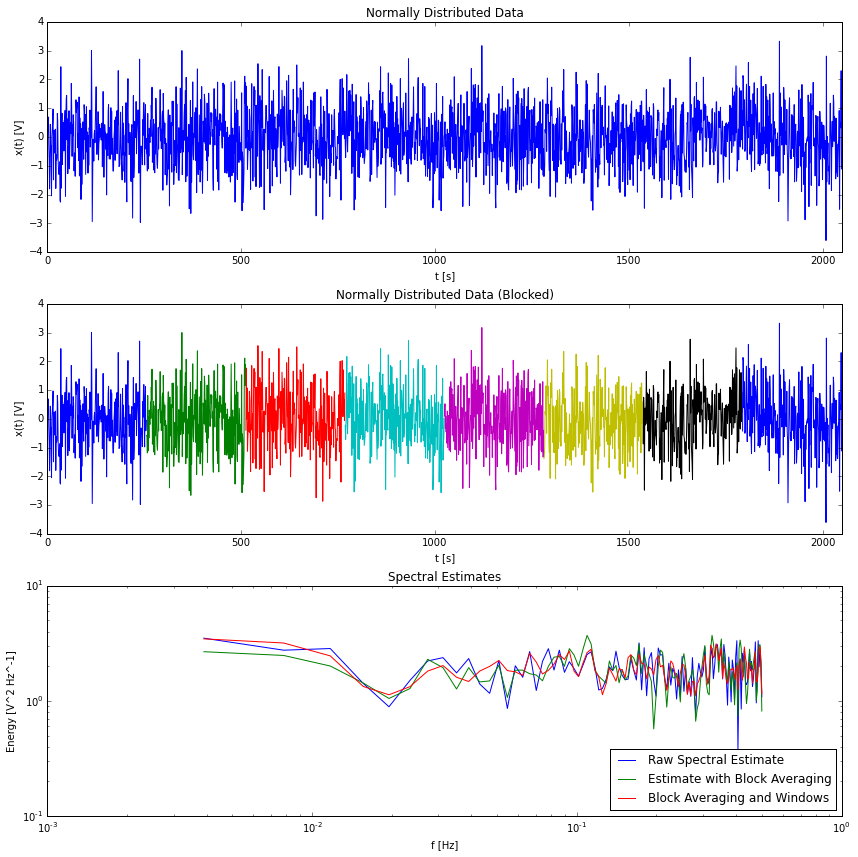

In [2]:
# Funcion for examining the data before answering the question
def examine(N,dt,nfft):
    x = np.random.normal(0,1,N)
    t = np.arange(N)

    T = N*dt
    Nblocks = N/nfft
    blockSize = nfft
    
    # Raw estimate 
    rawEstimate,freqRaw = mlab.psd(x,NFFT=nfft,Fs=1./dt,window=mlab.window_none,noverlap=0)
    dofRaw = 2.
    # Block averaging with no overlap
    blockNoOverlap,freqNoOverlap = mlab.psd(x,NFFT=nfft,Fs=1./dt,window=mlab.window_hanning,noverlap=0)
    dofBlock = 2.*N/nfft
    # Block averaging with 50% overlap Hanning windows
    blockWindows,freqWindows = mlab.psd(x,NFFT=nfft,Fs=1./dt,window=mlab.window_hanning,noverlap=nfft/2)
    dofOverlap = 2.*N/(nfft*2-1)

    # Graph the data before putting it in histograms
    plt.figure(figsize=(12,12))
    gs=gridspec.GridSpec(3,1)

    # graph normal data
    ax1=plt.subplot(gs[0:1])
    ax1.plot(t,x,label='x(t)')
    ax1.set_xlabel('t [s]')
    ax1.set_ylabel('x(t) [V]')
    ax1.set_title('Normally Distributed Data')
    ax1.set_xlim(right=t[-1])

    # graph blocked data
    ax2=plt.subplot(gs[1:2])
    for ind in range(Nblocks):
        inds =range(ind*blockSize,(ind+1)*blockSize)
        tblock=t[inds]
        xblock=x[inds]
        #print len(xblock)
        ax2.plot(tblock,xblock)
    ax2.set_xlabel('t [s]')
    ax2.set_ylabel('x(t) [V]')
    ax2.set_title('Normally Distributed Data (Blocked)')
    ax2.set_xlim(right=t[-1])

    # graph spectral estimates
    ax3=plt.subplot(gs[2:3])
    ax3.plot(freqRaw,rawEstimate,label='Raw Spectral Estimate')
    ax3.plot(freqNoOverlap,blockNoOverlap,label='Estimate with Block Averaging')
    ax3.plot(freqWindows,blockWindows,label='Block Averaging and Windows')
    ax3.set_xlabel('f [Hz]')
    ax3.set_ylabel('Energy [V^2 Hz^-1]')
    ax3.set_title('Spectral Estimates')
    ax3.legend(loc=4)
    ax3.loglog()

    plt.tight_layout()
    
    
# Gather data
N = 2048
dt = 1 # hour
nfft = 256 # block length
examine(N,dt,nfft)

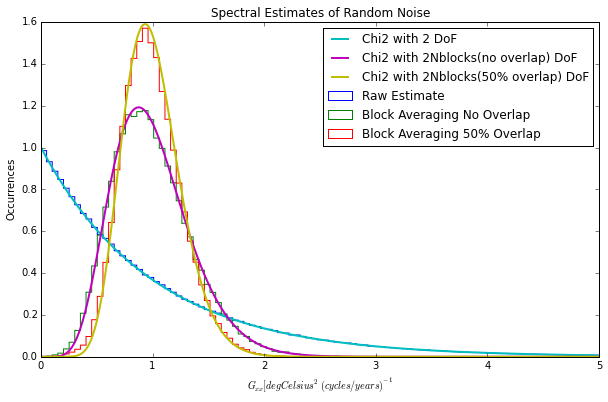

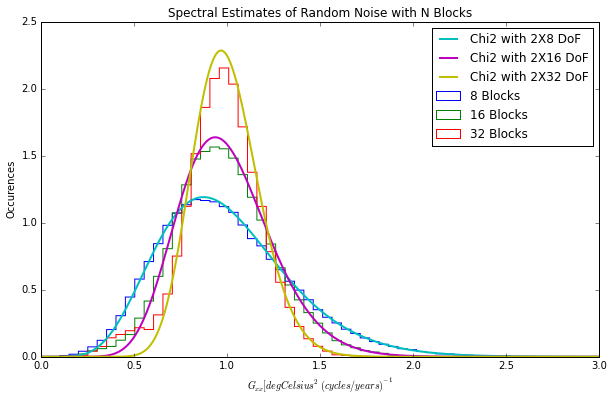

In [3]:
# Function to compare histograms of Nexps trials with Chi squared PDFs
def monteCarlo(Nexps,N,dt,nfft):

    GridRaw = np.ndarray((Nexps,N/2+1))
    GridBlock = np.ndarray((Nexps,nfft/2+1))
    GridOverlap = np.ndarray((Nexps,nfft/2+1))

    for i in range(Nexps):
        x = np.random.normal(0,1,N)
        t = np.arange(N)

        # Raw estimate 
        rawEstimate,freqRaw = mlab.psd(x,NFFT=N,Fs=1./dt,window=mlab.window_none,noverlap=0)
        GridRaw[i,:] = rawEstimate
        
        # Block averaging with no overlap
        blockNoOverlap,freqNoOverlap = mlab.psd(x,NFFT=nfft,Fs=1./dt,window=mlab.window_hanning,noverlap=0)
        #print 'f',len(freqNoOverlap)
        GridBlock[i,:] = blockNoOverlap
        
        # Block averaging with 50% overlap Hanning windows
        blockWindows,freqWindows = mlab.psd(x,NFFT=nfft,Fs=1./dt,window=mlab.window_hanning,noverlap=256/2)
        GridOverlap[i,:] = blockWindows

    # Scale and flatten the data
    GridRaw = GridRaw/2.
    rawEstimate = GridRaw.flat
    GridBlock = GridBlock/2.
    blockEstimate = GridBlock.flat
    GridOverlap = GridOverlap/2.
    overlapEstimate = GridOverlap.flat

    # Plot Histograms Together
    bins = np.linspace(0,5,100)#50

    plt.figure(figsize=(10,6))
    gs=gridspec.GridSpec(1,1)
    ax=plt.subplot(gs[0:1])
    ax.hist(rawEstimate,bins,label='Raw Estimate',histtype='step',normed=True)
    ax.hist(blockEstimate,bins,label='Block Averaging No Overlap',histtype='step',normed=True)
    ax.hist(overlapEstimate,bins,label='Block Averaging 50% Overlap',histtype='step',normed=True)

    # Theoretical PDF's
    x = np.linspace(0,5,1000)
    dof2=2
    chi2 = stats.chi2.pdf(x,2,scale=1./dof2)
    dof2N_block = 2.*N/nfft
    chi2N_block = stats.chi2.pdf(x,dof2N_block,scale=1./dof2N_block)
    dof2N_overlap = 2.*(N/nfft+N/nfft-1)
    chi2N_overlap = stats.chi2.pdf(x,dof2N_overlap,scale=1./dof2N_overlap)

    # Plot theoretical PDF's
    ax.plot(x,chi2,label='Chi2 with 2 DoF',linewidth=2)
    ax.plot(x,chi2N_block,label='Chi2 with 2Nblocks(no overlap) DoF',linewidth=2)
    ax.plot(x,chi2N_overlap,label='Chi2 with 2Nblocks(50% overlap) DoF',linewidth=2)

    ax.set_xlabel('$G_{xx} [deg Celsius^2 (cycles/years)^{-1}$')
    ax.set_ylabel('Occurrences')
    ax.legend()
    ax.set_xlim(left=0,right=5)
    ax.set_title('Spectral Estimates of Random Noise')
    
    return overlapEstimate

# Function to compare multiple Nblocks values for blocks with no overlap
def compareNblocks(Nexps,N,dt,nfft1,nfft2,nfft3):
    Grid1 = np.ndarray((Nexps,nfft/2+1))
    Grid2 = np.ndarray((Nexps,nfft2/2+1))
    Grid3 = np.ndarray((Nexps,nfft3/2+1))

    for i in range(Nexps):
        x = np.random.normal(0,1,N)
        t = np.arange(N)
        
        # Grid 1
        g,f = mlab.psd(x,NFFT=nfft,Fs=1./dt,window=mlab.window_none,noverlap=0)
        Grid1[i,:] = g
        
        # Grid 2
        gg,ff = mlab.psd(x,NFFT=nfft2,Fs=1./dt,window=mlab.window_none,noverlap=0)
        Grid2[i,:] = gg
        
        # Grid 3
        ggg,fff = mlab.psd(x,NFFT=nfft3,Fs=1./dt,window=mlab.window_none,noverlap=0)
        Grid3[i,:] = ggg
        
    # Scale and flatten the data
    Grid1 = Grid1/2.
    est1 = Grid1.flat
    Grid2 = Grid2/2.
    est2 = Grid2.flat
    Grid3 = Grid3/2.
    est3 = Grid3.flat
    
    # Plot Histograms Together
    blocks1 = N/nfft
    blocks2 = N/nfft2
    blocks3 = N/nfft3
    bins = np.linspace(0,5,100)#50

    plt.figure(figsize=(10,6))
    gs=gridspec.GridSpec(1,1)
    ax=plt.subplot(gs[0:1])
    ax.hist(est1,bins,label='%d Blocks'%blocks1,histtype='step',normed=True)
    ax.hist(est2,bins,label='%d Blocks'%blocks2,histtype='step',normed=True)
    ax.hist(est3,bins,label='%d Blocks'%blocks3,histtype='step',normed=True)
    ax.set_title('Spectral Estimates of Random Noise with N Blocks')
    ax.set_xlabel('$G_{xx} [deg Celsius^2 (cycles/years)^{-1}$')
    ax.set_ylabel('Occurences')
    ax.set_xlim(left=0,right=3)
    
    # Plot Chi 2 fits
    x = np.linspace(0,5,1000)
    dof1 = 2.*blocks1
    chi1 = stats.chi2.pdf(x,dof1,scale=1./dof1)
    dof2 = 2.*blocks2
    chi2 = stats.chi2.pdf(x,dof2,scale=1./dof2)
    dof3 = 2.*blocks3
    chi3 = stats.chi2.pdf(x,dof3,scale=1./dof3)

    # Plot theoretical PDF's
    ax.plot(x,chi1,label='Chi2 with 2X%d DoF'%blocks1,linewidth=2)
    ax.plot(x,chi2,label='Chi2 with 2X%d DoF'%blocks2,linewidth=2)
    ax.plot(x,chi3,label='Chi2 with 2X%d DoF'%blocks3,linewidth=2)
    ax.legend()
    
# Run the analysis
Nexps = 1000
overlapEstimate = monteCarlo(Nexps,N,dt,nfft)

# Compare different numbers of blocks for non-overlap case
nfft2 = nfft/2
nfft3 = nfft2/2
compareNblocks(Nexps,N,dt,nfft,nfft2,nfft3)

The 'Spectral Estimates of Random Noise' graph (above) shows that after collecting data using the Monte Carlo technique of 1000 trials, the histogram of raw spectral estimates is indeed distributed as Chi Squared with DOF=2. Similarly, the histogram of estimates using block averaging is distributed as Chi Squared with DOF=2Nblocks (where the number of blocks is the length of the data N divided by the length of the blocks nfft). Similarly still, the histogram of estimates using block averaging and hanning windows with 50% overlap is also distributed as Chi Squared with DOF=2Nblocks, where the number of blocks is now 2 times Nblocks without overlap, minus one. 

The 'Spectral Estimates of Random Noise with N Blocks' graph (above) shows visually that the spread in data decreases as Nblocks increases. This means that the variance is decreasing and the distributions are getting tighter with larger number of blocks.

<div style='background:#F0F0F0'>**2**  For the Hanning window estimate, what fits better: $2N_{blocks}$ degrees of freedom or $18N_{blocks}/11$ degrees of freedom (the correct theoretical value)?  Its OK to evaluate by eye.</div>

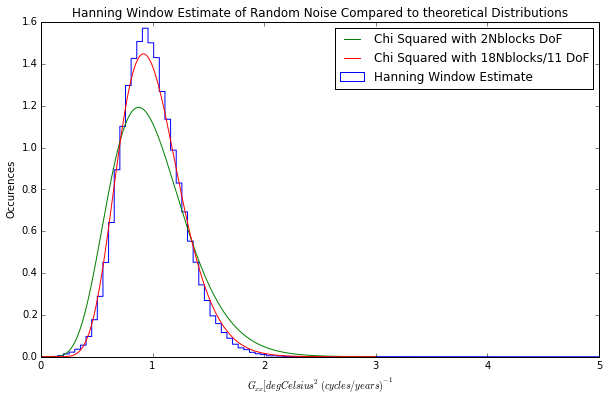

In [5]:
# Function to compare the hanning estimate with two chi squared PDFs
def compareHanning(overlapEstimate,N,nfft):
    #bins = 50
    bins = np.linspace(0,5,100)
    
    # Plot it
    plt.figure(figsize=(10,6))
    gs=gridspec.GridSpec(1,1)
    ax=plt.subplot(gs[0:1])
    nn,binsH,patches = ax.hist(overlapEstimate,bins,label='Hanning Window Estimate',histtype='step',normed=True)

    # Get the Chi Squared PDFs
    x = np.linspace(0,3,1000)
    dof2N = 2.*N/nfft
    chi2N = stats.chi2.pdf(x,dof2N,scale=1./dof2N)
    dof18N11 = 18.*(N/nfft+N/nfft-1)/11.
    chi18N11 = stats.chi2.pdf(x,dof18N11,scale=1./dof18N11)

    # Plot them
    ax.plot(x,chi2N,label='Chi Squared with 2Nblocks DoF')
    ax.plot(x,chi18N11,label='Chi Squared with 18Nblocks/11 DoF')
    
    ax.set_title('Hanning Window Estimate of Random Noise Compared to theoretical Distributions')
    ax.set_xlabel('$G_{xx} [deg Celsius^2 (cycles/years)^{-1}$')
    ax.set_ylabel('Occurences')

    ax.legend()
    
compareHanning(overlapEstimate,N,nfft)

The above graph shows visually that the Chi Squared distribution with 18Nblocks/11 DOF fits better to the Hanning window estimate PDF than the Chi Squared with 2Nblocks DOF. This is nice to see as 18Nblocks/11 is the theoretical value.

## Q2: Spectra of a "red-noise" signal

<div style='background:#F0F0F0'> **1** Load in the Deep Cove hourly data, and compute the power spectra using some reasonable value for $N_{FFT}$, and comment on the effect of applying the Hanning window to not applying it to the spectral leakage.</div>

In [6]:
# LOAD
hourdata=np.genfromtxt('http://web.uvic.ca/~jklymak/Phy411/Data/AllHourly.txt')[[6,28],2:]
dc = hourdata[0,:]
dc=dc[np.isfinite(dc)]

Hours recorded =  24357
Hours in year =  8766.0
Years recorded =  2.77857631759


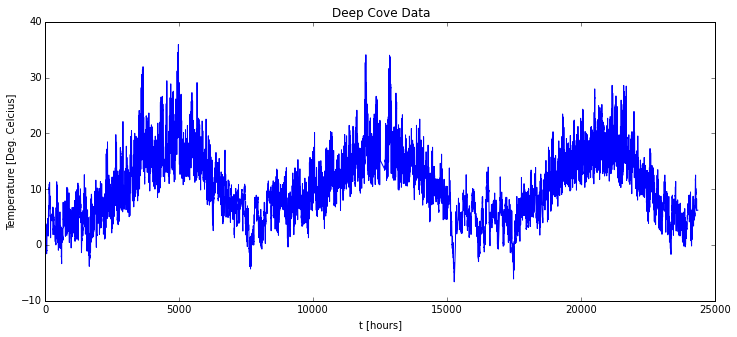

In [7]:
# Funcion for examining the data before answering the question
def plotData(dc,hours,oneyear,years):
    t = np.arange(len(dc))
    plt.figure(figsize=(12,5))
    gs=gridspec.GridSpec(1,1)
    ax=plt.subplot(gs[0:1])
    ax.plot(t,dc)
    ax.set_title('Deep Cove Data')
    ax.set_xlabel('t [hours]')
    ax.set_ylabel('Temperature [Deg. Celcius]')  
    
    print 'Hours recorded = ',hours
    print 'Hours in year = ',oneyear
    print 'Years recorded = ',years  
    

hours = len(dc)
oneyear = 24*365.25
years = hours/oneyear
plotData(dc,hours,oneyear,years)

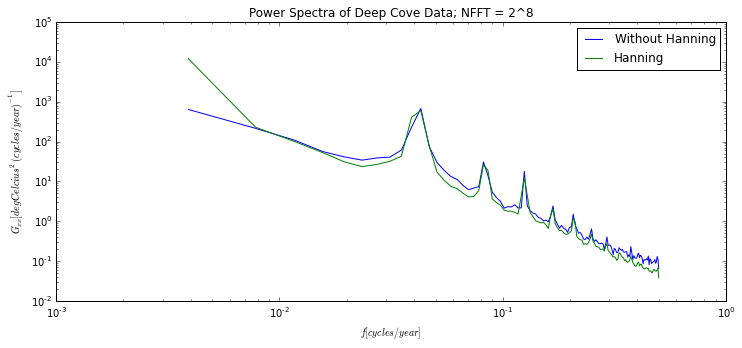

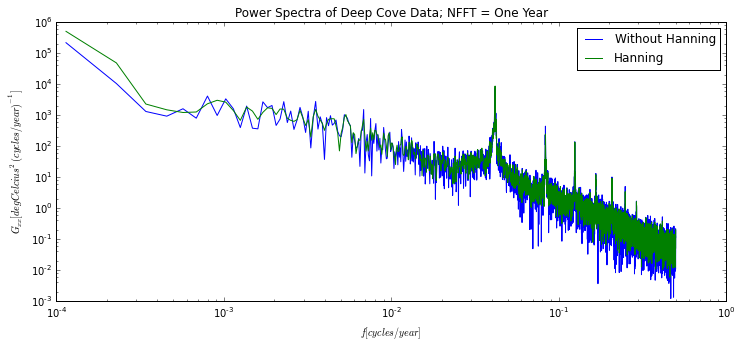

In [19]:
# Function to plot the periodigram
def plotSpectra(f,G):
    plt.figure(figsize=(12,5))
    gs=gridspec.GridSpec(1,1)
    ax=plt.subplot(gs[0:1])
    ax.plot(f,G,label='Without Hanning')
    ax.set_title('Power Spectra of Deep Cove Data')
    ax.set_xlabel('$f [cycles/year]$')
    ax.set_ylabel('$G_{xx} [deg Celcius^2 (cycles/year)^{-1}]$')
    ax.loglog()
    return ax

#Calculate and Plot
dt = 1 # 3600 # year

# Block size a power of 2
nfft = 2**8
GG,ff = mlab.psd(dc,NFFT=nfft,Fs=1./dt,window=mlab.window_none,noverlap=0)
ax = plotSpectra(ff,GG)
    
GGH,ffH = mlab.psd(dc,NFFT=nfft,Fs=1./dt,window=mlab.window_hanning,noverlap=nfft/2)
ax.plot(ffH,GGH,label='Hanning')
ax.legend()
ax.set_title('Power Spectra of Deep Cove Data; NFFT = 2^8')

# Block size the length of one year
nfft = int(oneyear)
GG,ff = mlab.psd(dc,NFFT=nfft,Fs=1./dt,window=mlab.window_none,noverlap=0)
ax = plotSpectra(ff,GG)
    
GGH,ffH = mlab.psd(dc,NFFT=nfft,Fs=1./dt,window=mlab.window_hanning,noverlap=nfft/2)
ax.plot(ffH,GGH,label='Hanning')
ax.legend()
ax.set_title('Power Spectra of Deep Cove Data; NFFT = One Year')

I have plotted two graphs. The first shows the difference between Hanning and No Hanning windows when the block size is a power of 2, and the second shows the same when the block size is the number of hours is one year (for our yearly data).

The first graph clearly demonstrates how the sidelobe leakage is decreased when Hanning Windows are used; The energy levels on either side of each frequency peak have been reduced by using Hanning Windows when compared to the original.

The second graph uses a more realistic value for NFFT given the data has a yearly cycle (NFFT = one year). This value causes the blocks of the data to be better correlated with each other. Since there are only 2.7 years of data, the second graph appears noisier making it more difficult to tell how the hanning windows affect the sidelobe leakage (which is why the first graph was included for comparison). You can, however, still see that the blue (no hanning) plot is higher on either side of each peak than the green (hanning) plot. 

<div style='background:#F0F0F0'> **2** Now do the same thing to the intergal of the Deep Cove data with time: $$y(t)=\int_o^t x(t')\ \mathrm{d}t'$$  This is obviously a silly thing to do, but compare the spectra and comment on the difference between the Hanning window and the non-Hanning windowed data.  </div>

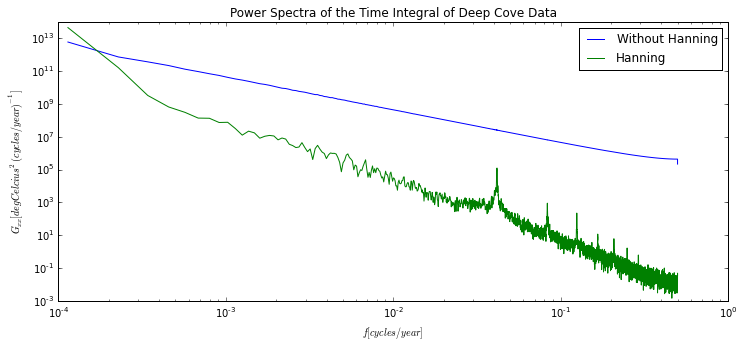

In [9]:
# Calculate the integral
y = np.cumsum(dc) # because dt = 1 year the integral is just the sum of all x(t) values

# Calulate and plot the spectra without hanning
GGy,ffy = mlab.psd(y,NFFT=nfft,Fs=1./dt,window=mlab.window_none,noverlap=0)
ax = plotSpectra(ffy,GGy)
    
# Calculate and plot the spectra with 50% hanning windows
GGHy,ffHy = mlab.psd(y,NFFT=nfft,Fs=1./dt,window=mlab.window_hanning,noverlap=nfft/2)
ax.plot(ffHy,GGHy,label='Hanning')
ax.legend()
ax.set_title('Power Spectra of the Time Integral of Deep Cove Data')

YOUR ANSWER HERE

Here, the Hanning Windowed data has lower energies for the higher frequencies than it does without Hanning Windows. The Hanning Windows allow us to see peak frequencies similar to those in the non-integrated data. It's interesting to see that the estimate without Hanning Windows is nearly linear - this is believed to be due to the fact that each data point in y depends directly on the datapoint before it. 